### Alle Gewerke 'dumm' simuliert

PLZ: 40599, Jahr 2016
- PV = 10 kWp
- Elekt. Verbrauch
- BS = 10 kWh
- EV (dumm) = 72 kWh
- WP (dumm, Müsterprofil)

PV & Elekt. Verbrauch

In [23]:
# PV & Elekt. Verbrauch einlesen aus elecdemandhourly240723.csv

import pandas as pd

dumm = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\elecdemandhourly240723.csv')

# Drop 'Eigenverbrauch' & 'Einspeisung'
dumm = dumm.drop(['sub', 'Netzbezug', 'Eigenverbrauch', 'Einspeisung'], axis=1)
dumm.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
dumm.rename(columns={'h0_dyn': 'Hausverbrauch'}, inplace=True)
dumm['time'] = pd.to_datetime(dumm['time'])
dumm.set_index('time', inplace=True)
dumm


,Hausverbrauch,pv
time,,
2016-01-01 00:00:00,0.386959,0.0
2016-01-01 01:00:00,0.278753,0.0
2016-01-01 02:00:00,0.223167,0.0
2016-01-01 03:00:00,0.203622,0.0
2016-01-01 04:00:00,0.191801,0.0
...,...,...
2016-12-31 19:00:00,1.061405,0.0
2016-12-31 20:00:00,0.868713,0.0
2016-12-31 21:00:00,0.677457,0.0


E-Auto
- ev_dumm Profile einlesen
- Simuliert mit folgenden annahmen:
    - car_efficiency = 191 / 1000  # kWh per km
    -  battery_capacity = 72  # kWh
    - battery_min = 10  # %
    - battery_max = 80  # %
    - min_battery_level = battery_min / 100 * battery_capacity  # kWh
    - max_battery_level = battery_max / 100 * battery_capacity  # kWh
    - max_charge_power = 11  # kW

In [24]:
# Homeoffice = True
homeoffice_t = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\ev_dumm_true.csv')
homeoffice_t.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
homeoffice_t['time'] = pd.to_datetime(homeoffice_t['time'])
homeoffice_t.set_index('time', inplace=True)

# Homeoffice = False
# homeoffice_f = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\ev_dumm_false.csv')

dumm = pd.concat([dumm, homeoffice_t], axis=1)
dumm = dumm.drop(['Energy_used_total'], axis=1)
dumm.rename(columns={'Grid_used': 'EV_verbrauch'}, inplace=True)
dumm

,Hausverbrauch,pv,EV_battery,EV_at_home,EV_verbrauch
time,,,,,
2016-01-01 00:00:00,0.386959,0.0,57.6,1.0,0.000
2016-01-01 01:00:00,0.278753,0.0,57.6,1.0,0.000
2016-01-01 02:00:00,0.223167,0.0,57.6,1.0,0.000
2016-01-01 03:00:00,0.203622,0.0,57.6,1.0,0.000
2016-01-01 04:00:00,0.191801,0.0,57.6,1.0,0.000
...,...,...,...,...,...
2016-12-31 19:00:00,1.061405,0.0,57.6,1.0,5.504
2016-12-31 20:00:00,0.868713,0.0,57.6,1.0,0.000
2016-12-31 21:00:00,0.677457,0.0,57.6,1.0,0.000


Batteriespeicher

In [25]:
# Battery parameters
battery_capacity = 10  # kWh
c_rate = 1
charge_efficiency = 0.96 # BYD HVS & HVM
discharge_efficiency = 0.96
charging_power = c_rate * battery_capacity * charge_efficiency # kW
min_soc = 1
max_soc = battery_capacity
battery_soc = 5  # Initial state of charge in kWh (50% of battery capacity)
charge_efficiency = 0.96 # BYD HVS & HVM
discharge_efficiency = 0.96

# Adding columns to the DataFrame for the simulation results
dumm['battery_soc'] = 0.0
dumm['battery_charge'] = 0.0
dumm['battery_discharge'] = 0.0
dumm['grid_export'] = 0.0
dumm['pv_excess'] = 0.0
dumm['grid_import'] = 0.0
dumm['eigenverbrauch'] = 0.0

# Simulation loop
for i in range(len(dumm)):
    pv_production = dumm.iloc[i]['pv']
    ac_consumption = dumm.iloc[i] ['Hausverbrauch'] # Verbrauchsstromprofil
    ev_consumption = dumm.iloc[i] ['EV_verbrauch']

    if pv_production >= (ac_consumption + ev_consumption):
        # Surplus PV production
        surplus = pv_production - ac_consumption - ev_consumption

        # Charge the battery with the surplus, limited by the charging power and max_soc
        charge_potential = surplus * charge_efficiency
        charge_to_battery = min(charge_potential, max_soc - battery_soc)

        # Update battery state of charge
        battery_soc += charge_to_battery

        # Calculate excess PV after charging battery
        pv_excess = surplus - (charge_to_battery / charge_efficiency)

        # Energy to be exported to the grid
        grid_export = pv_excess

        # Update DataFrame
        dumm.iloc[i]['battery_charge'] = charge_to_battery
        dumm.iloc[i]['grid_export'] = grid_export
        dumm.iloc[i]['pv_excess'] = pv_excess
        dumm.iloc[i]['grid_import'] = 0.0  # No grid import in surplus case
        dumm.iloc[i]['eigenverbrauch'] = ac_consumption

    else:
        # PV production is less than AC consumption
        shortfall = (ac_consumption + ev_consumption) - pv_production

        # Discharge battery to meet the shortfall, limited by discharging power and min_soc
        discharge_needed = min(shortfall / discharge_efficiency, charging_power)
        discharge_from_battery = min(discharge_needed, battery_soc-min_soc)

        # Actual energy supplied to AC from battery
        energy_from_battery = discharge_from_battery * discharge_efficiency

        # Update battery state of charge
        battery_soc -= discharge_from_battery
       
        # Calculate any remaining shortfall after battery discharge
        remaining_shortfall = shortfall - energy_from_battery

        # Energy imported from the grid to cover the remaining shortfall
        grid_import = remaining_shortfall if remaining_shortfall > 0 else 0.0

        # Update DataFrame
        dumm.iloc[i]['battery_discharge'] = discharge_from_battery
        dumm.iloc[i]['grid_import'] = grid_import
        dumm.iloc[i]['grid_export'] = 0.0  # No grid export in deficit case
        dumm.iloc[i]['pv_excess'] = 0.0  # No excess PV in deficit case
        dumm.iloc[i]['eigenverbrauch'] = energy_from_battery + pv_production

    # Update SOC in the DataFrame
    dumm.iloc[i]['battery_soc'] = battery_soc

dumm

C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_13708\816173458.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dumm.iloc[i]['battery_discharge'] = discharge_from_battery
C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_13708\816173458.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dumm.iloc[i]['grid_import'] = grid_import
C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_13708\816173458.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,Hausverbrauch,pv,EV_battery,EV_at_home,EV_verbrauch,battery_soc,battery_charge,battery_discharge,grid_export,pv_excess,grid_import,eigenverbrauch
time,,,,,,,,,,,,
2016-01-01 00:00:00,0.386959,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.278753,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.223167,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.203622,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.191801,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1.061405,0.0,57.6,1.0,5.504,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 20:00:00,0.868713,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 21:00:00,0.677457,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Wärmepumpe
- T_amb mit meteostat_temperature.py generiert: T_amb_40599_2016.csv

In [26]:
t_amb = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\T_amb_40599_2016.csv')
t_amb['time'] = pd.to_datetime(t_amb['time'])
t_amb.set_index('time', inplace=True)
dumm = pd.concat([dumm, t_amb], axis=1)

# Stündliche Werte in Mittelwerte pro Tag konvertieren
t_amb = t_amb.resample('24h').mean()

# Müster Profil einlesen
t_amb_muester = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\Muester_Tamb_Essen_1.csv')
t_amb_muester['time'] = pd.to_datetime(t_amb_muester['time'])
t_amb_muester.set_index('time', inplace=True)
t_amb_muester.index = t_amb_muester.index.map(lambda x: x.replace(year=2016))

# WP Verbrauchsprofil einlesen
wp_profil = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\t_amb_profile_241112.csv')
wp_profil['time'] = pd.to_datetime(wp_profil['time'])
wp_profil.set_index('time', inplace=True)
wp_profil.index = wp_profil.index.map(lambda x: x.replace(year=2016))

# wp_profil['time'] = pd.to_datetime(wp_profil['time'])
# wp_profil.set_index('time', inplace=True)
# wp_profil.index = wp_profil.index.map(lambda x: x.replace(year=2016))


# Erstellen eines neuen DataFrames wp_neu mit dem gleichen Index wie wp_profil
wp_neu = pd.DataFrame(index=wp_profil.index, columns=['WP_verbrauch'])

# Schleife durch jeden Eintrag (Datum und Temperatur) in t_amb_standort
for date_standort, temp_standort in t_amb['temp'].items():
    # Berechnung des absoluten Temperaturunterschieds zwischen temp_standort und allen Werten in t_amb_muester
    temp_diffs = (t_amb_muester['temp'] - temp_standort).abs()
    
    # Finden des Tages in t_amb_muester mit der minimalen Temperaturdifferenz
    nearest_date = temp_diffs.idxmin()  # Datum in t_amb_muester mit geringstem Temperaturunterschied
    
    # Debugging-Ausgabe, um sicherzustellen, dass das Datum und die Temperatur gefunden wurden
    print(f"Für das Datum {date_standort} und die Temperatur {temp_standort} °C:")
    print(f"  -> Am nächsten liegendes Datum in t_amb_muester: {nearest_date} mit Temperatur {t_amb_muester.loc[nearest_date, 'temp']} °C")

    # Kopieren der stündlichen WP-Verbrauchsdaten für das Datum in wp_neu für den gesamten Tag
    mask_standort = wp_profil.index.normalize() == date_standort
    mask_nearest = wp_profil.index.normalize() == nearest_date
    
    # Überprüfen der Anzahl der Einträge, um sicherzustellen, dass die Längen übereinstimmen
    if len(wp_profil.loc[mask_nearest, 'WP (Wh)']) == len(wp_neu.loc[mask_standort, 'WP_verbrauch']):
        wp_neu.loc[mask_standort, 'WP_verbrauch'] = wp_profil.loc[mask_nearest, 'WP (Wh)'].values
        print(f"  -> WP-Verbrauchsdaten für {date_standort} erfolgreich kopiert.")
    else:
        print(f"  -> Unterschiedliche Längen: {len(wp_profil.loc[mask_nearest, 'WP (Wh)'])} vs {len(wp_neu.loc[mask_standort, 'WP_verbrauch'])}")

wp_neu




Für das Datum 2016-01-01 00:00:00 und die Temperatur 5.866666666666667 °C:
  -> Am nächsten liegendes Datum in t_amb_muester: 2016-04-23 00:00:00 mit Temperatur 5.820833333333333 °C
  -> WP-Verbrauchsdaten für 2016-01-01 00:00:00 erfolgreich kopiert.
Für das Datum 2016-01-02 00:00:00 und die Temperatur 5.0249999999999995 °C:
  -> Am nächsten liegendes Datum in t_amb_muester: 2016-04-17 00:00:00 mit Temperatur 4.970833333333333 °C
  -> WP-Verbrauchsdaten für 2016-01-02 00:00:00 erfolgreich kopiert.
Für das Datum 2016-01-03 00:00:00 und die Temperatur 6.191666666666666 °C:
  -> Am nächsten liegendes Datum in t_amb_muester: 2016-04-25 00:00:00 mit Temperatur 6.216666666666666 °C
  -> WP-Verbrauchsdaten für 2016-01-03 00:00:00 erfolgreich kopiert.
Für das Datum 2016-01-04 00:00:00 und die Temperatur 5.383333333333333 °C:
  -> Am nächsten liegendes Datum in t_amb_muester: 2016-04-21 00:00:00 mit Temperatur 5.545833333333333 °C
  -> WP-Verbrauchsdaten für 2016-01-04 00:00:00 erfolgreich kopi

,WP_verbrauch
time,
2016-01-01 00:00:00,660.84725
2016-01-01 01:00:00,1173.09475
2016-01-01 02:00:00,1152.58375
2016-01-01 03:00:00,1066.5925
2016-01-01 04:00:00,755.0145
...,...
2016-11-21 17:00:00,NaN
2016-11-21 18:00:00,NaN
2016-11-21 19:00:00,NaN


In [27]:
wp_neu['WP_verbrauch'] = wp_neu['WP_verbrauch'].div(1000)
wp_neu

,WP_verbrauch
time,
2016-01-01 00:00:00,0.660847
2016-01-01 01:00:00,1.173095
2016-01-01 02:00:00,1.152584
2016-01-01 03:00:00,1.066593
2016-01-01 04:00:00,0.755015
...,...
2016-11-21 17:00:00,NaN
2016-11-21 18:00:00,NaN
2016-11-21 19:00:00,NaN


In [28]:
dumm = pd.concat([dumm, wp_neu], axis=1)
dumm

,Hausverbrauch,pv,EV_battery,EV_at_home,EV_verbrauch,battery_soc,battery_charge,battery_discharge,grid_export,pv_excess,grid_import,eigenverbrauch,temp,WP_verbrauch
time,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.386959,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.1,0.660847
2016-01-01 01:00:00,0.278753,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.8,1.173095
2016-01-01 02:00:00,0.223167,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.1,1.152584
2016-01-01 03:00:00,0.203622,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.4,1.066593
2016-01-01 04:00:00,0.191801,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.755015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1.061405,0.0,57.6,1.0,5.504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,NaN
2016-12-31 20:00:00,0.868713,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,NaN
2016-12-31 21:00:00,0.677457,0.0,57.6,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.8,NaN


#### Plots

<Axes: xlabel='time'>

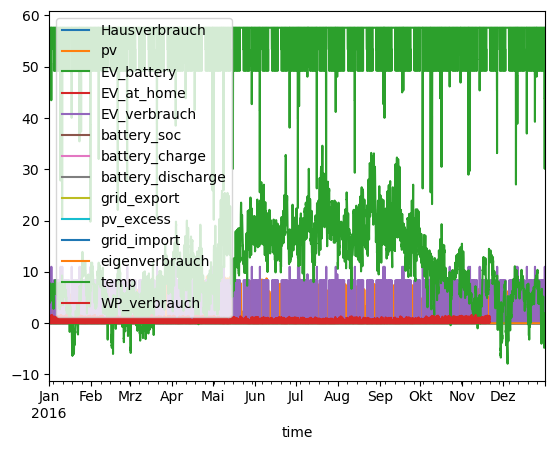

In [29]:
import matplotlib.pyplot as plt 

dumm.plot()

In [1]:
# 1 Tag: 4.1.2016
tag = dumm.loc['2016-02-04 00:00:00':'2016-02-04 23:00:00', ['pv', 'EV_verbrauch', 'battery_soc', 'WP_verbrauch', 'Hausverbrauch']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Energy (kWh)')
plt.grid(True)
plt.show

NameError: name 'dumm' is not defined

<function matplotlib.pyplot.show(close=None, block=None)>

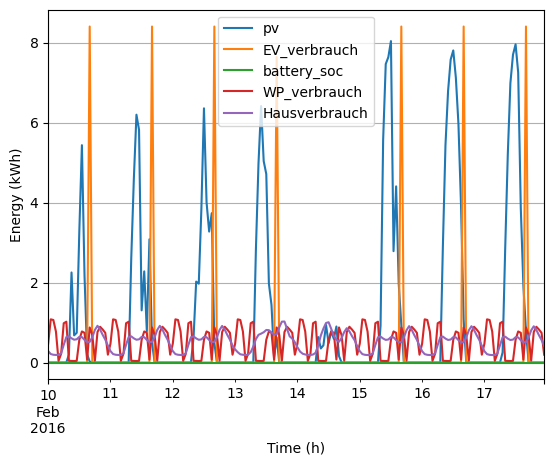

In [34]:
# 1 Woche: 10.-17.2.2016
tag = dumm.loc['2016-02-10 00:00:00':'2016-02-17 23:00:00', ['pv', 'EV_verbrauch', 'battery_soc', 'WP_verbrauch', 'Hausverbrauch']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Energy (kWh)')
plt.grid(True)
plt.show